In [1]:
# !pip install wordcloud --proxy http://192.168.95.100:3128 --trusted-host files.pythonhosted.org

# START

In [2]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn
Connected oraDW_ANALYTICS - conn_aly


# INPUT DATA - RAW DATA

In [3]:
# SAMPLE3 = '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DEMO_SAMPLE1_SUB3'
DEMOGRAPHIC_SAMPLE3 = '/config/workspace/feature-store/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_CUSTOMER_FULL_DIM/SAMPLE1_SUB3'
CUST_STATUS_SAMPLE3 = '/config/workspace/feature-store/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DATA_RPT_SLKH_CUST_PRODUCT_ALL/SAMPLE1_SUB3'
CARD_TXN_FCT = '/config/workspace/feature-store/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_CARD_TRANSACTION_FCT/SAMPLE1_SUB3'
DEPOSIT_FCT = '/config/workspace/feature-store/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DW_DEPOSIT_FCT/SAMPLE1_SUB3'

In [4]:
credit_score_sql = """WITH 
T0 AS (
    SELECT 
        TRIM(' ' FROM(CUSTOMER_CDE))CUSTOMER_CDE,
        NVL(FINANCIALSCORE, NONFINANCIALSCORE) CREDIT_SCORE,
        RANK()OVER(PARTITION BY CUSTOMER_CDE ORDER BY DATE_1 DESC)RANK_SCORE, 
        DATE_1,
        PROCESS_DATE
     FROM DW_ANALYTICS.STG_CRS_CUSTOMER_SCORE
),
T1 AS (
    SELECT 
        CUSTOMER_CDE,
        CREDIT_SCORE,
        DATE_1,
        PROCESS_DATE,
        ROW_NUMBER() OVER(PARTITION BY CUSTOMER_CDE ORDER BY CREDIT_SCORE DESC) RN
    FROM T0
    WHERE RANK_SCORE = 1
    AND TO_DATE(DATE_1) < TO_DATE('31-12-23', 'DD-MM-YY')
),
T2 AS (
    SELECT CUSTOMER_CDE
    FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE SUB_SECTOR_CDE IN ('1700', '1602')
    AND ACTIVE = '1'
    AND COMPANY_KEY = '1'
),
T3 AS (
    SELECT T1.CUSTOMER_CDE, T1.CREDIT_SCORE
    FROM T1 RIGHT JOIN T2 ON T1.CUSTOMER_CDE = T2.CUSTOMER_CDE
    WHERE T1.RN = 1
),
T5 AS (
    SELECT 
        T3.CUSTOMER_CDE,
        CASE
          WHEN T3.CREDIT_SCORE IS NULL THEN 0
          ELSE T3.CREDIT_SCORE
        END CREDIT_SCORE
    FROM T3 INNER JOIN CINS_TMP_ALY_CUST_SAMPLE4 T4 ON T3.CUSTOMER_CDE = T4.CUSTOMER_CDE
    WHERE T3.CUSTOMER_CDE IS NOT NULL
    AND T4.CUSTOMER_CDE IS NOT NULL
)
SELECT * 
FROM T5
ORDER BY CREDIT_SCORE DESC
"""

In [5]:
reactivated_sql ="""WITH
T1 AS (
SELECT A.CUSTOMER_CDE, A.RPT_DT, A.CUST_STT, LAG(A.CUST_STT) OVER (PARTITION BY A.CUSTOMER_CDE ORDER BY A.RPT_DT) CUST_STT_LAG, 
A.CUST_STT - LAG(A.CUST_STT) OVER (PARTITION BY A.CUSTOMER_CDE ORDER BY A.RPT_DT) CUST_STT_CHG
FROM (
    SELECT T.CUSTOMER_CDE, T.PROCESS_DT RPT_DT,
        MAX(CASE
            WHEN T.CUST_STATUS = 'HOAT DONG' THEN 2
            WHEN T.CUST_STATUS = 'NGU DONG' THEN 1
            WHEN T.CUST_STATUS = 'DONG BANG' THEN 0
        END) CUST_STT
    FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT T
        JOIN CINS_TMP_ALY_CUST_SAMPLE4 C ON T.CUSTOMER_CDE=C.CUSTOMER_CDE
    WHERE 
        T.PROCESS_DT = ADD_MONTHS(TO_DATE('31-12-2023', 'DD-MM-YY'), -1)
        OR T.PROCESS_DT = TO_DATE('31-12-2023', 'DD-MM-YY')
    GROUP BY 
        T.CUSTOMER_CDE, 
        T.PROCESS_DT
) A),
T2 AS (
SELECT *
FROM T1
WHERE RPT_DT = TO_DATE('31-12-2023', 'DD-MM-YY')
)
SELECT * FROM T2"""

In [6]:
CARD_CREDIT_SUM_BAL_NOW = """SELECT CUSTOMER_CDE,
        SUM(TT_ORIGINAL_BALANCE) CARD_CREDIT_SUM_BAL_NOW,
        TO_DATE('31-12-23', 'DD-MM-YY') AS RPT_DT
FROM
  (SELECT BAL.*,
          ROW_NUMBER() OVER(PARTITION BY CUSTOMER_CDE, CARD_CDE
                            ORDER BY PROCESS_DT DESC) RN
   FROM
     (SELECT CUSTOMER_CDE,
             CARD_CDE,
             TT_ORIGINAL_BALANCE,
             PROCESS_DT
      FROM DW_ANALYTICS.DATA_RPT_CARD_493 CC
      WHERE PROCESS_DT < TO_DATE('31-12-23', 'DD-MM-YY')
        AND CUSTOMER_CDE IN
          (SELECT CUSTOMER_CDE
           FROM CINS_TMP_ALY_CUST_SAMPLE4)
        AND CARD_CDE LIKE '3%' ) BAL) BAL
WHERE RN = 1
GROUP BY CUSTOMER_CDE"""

## LOAD DATA

In [7]:
demographic = pd.read_pickle(DEMOGRAPHIC_SAMPLE3)
cust_status = pd.read_pickle(CUST_STATUS_SAMPLE3)
credit_data = download_or_reload('data/credit_score', credit_score_sql)

Len 9142


In [8]:
reactivated_data = download_or_reload('data/reactivated', reactivated_sql)

Len 494753


In [9]:
card_txn = pd.read_pickle(CARD_TXN_FCT)

In [10]:
# bao gom thong tin giao dich cua khach hang
stmt_ebank_df = pd.read_pickle('/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DWA_STMT_EBANK/SAMPLE1_SUB3')

FileNotFoundError: [Errno 2] No such file or directory: '/opt/bitnami/jupyterhub-singleuser/hcl-quanht/feature_store/adhoc/analyse-db/DW_ANALYTICS/data/DWA_STMT_EBANK/SAMPLE1_SUB3'

In [ ]:
card_credit_bal_now = download_or_reload('data/card_credit_bal_now', CARD_CREDIT_SUM_BAL_NOW)

## DATA SIZE

In [ ]:
demographic.shape, cust_status.shape, credit_data.shape, reactivated_data.shape, card_txn.shape

((500000, 83), (495227, 40), (9142, 2), (494753, 5), (11375912, 3))

## UNIQUE CUSTOMER

In [ ]:
demographic['CUSTOMER_CDE'].nunique(), cust_status['CUSTOMER_CDE'].nunique(), credit_data['CUSTOMER_CDE'].nunique(), reactivated_data['CUSTOMER_CDE'].nunique(), card_txn['CUSTOMER_CDE'].nunique(),

(500000, 495227, 9142, 494753, 169902)

In [ ]:
# Luoc bot thong tin
df1 = demographic[['CUSTOMER_CDE', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS', 'GENDER_CDE', 'PROVINCE_NM','CUS_OPEN_DT', 'DB_GRP_CIC']]

In [ ]:
cust_status.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT'],
      dtype='object')

# GENERAL INFO

<Axes: ylabel='CUST_TYPE'>

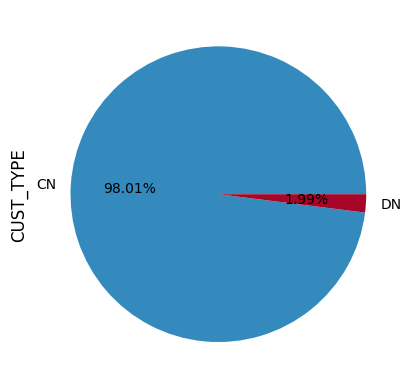

In [ ]:
cust_status['CUST_TYPE'].value_counts(dropna=False).plot(kind='pie',autopct='%.2f%%')

In [ ]:
df2 = cust_status.copy()

In [ ]:
# Khao sat KHCN
df2_1 = df2[df2['CUST_TYPE'] =='CN']

In [ ]:
df2_1['CUST_STATUS'].value_counts(dropna=False)

HOAT DONG    255625
DONG BANG    191075
NGU DONG      38681
Name: CUST_STATUS, dtype: int64

In [ ]:
df2_1['CUST_STATUS'] = df2_1['CUST_STATUS'].apply(lambda x: '1. HOAT DONG' if x == 'HOAT DONG' else '2. NGU DONG' if x == 'NGU DONG' else '3. DONG BANG')

<Axes: ylabel='CUST_STATUS'>

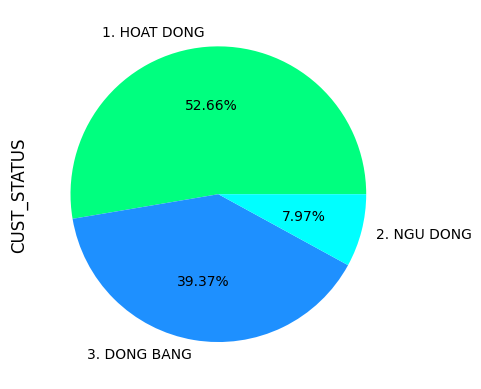

In [ ]:
df2_1[['CUSTOMER_CDE', 'CUST_STATUS']].drop_duplicates()['CUST_STATUS'].value_counts().plot(kind='pie', colors=['springgreen', 'dodgerblue', 'cyan'], autopct='%.2f%%')

## DATA-PREPROCESSED

In [ ]:
df3 = df2_1.merge(df1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
df3.CUSTOMER_CDE.nunique()

485381

In [ ]:
df3['LASTEST_TRANS_DT'].min()

Timestamp('2017-11-30 00:00:00')

In [ ]:
df3['LASTEST_TRANS_DT'].notnull().sum(), df3['LASTEST_TRANS_DT'].isnull().sum()

(304414, 180967)

## LASTEST_TRANS_DT

In [ ]:
tmp = df3.copy()

In [ ]:
min_latest_txn = df3['LASTEST_TRANS_DT'].min()

<Axes: ylabel='LASTEST_TRANS_DT'>

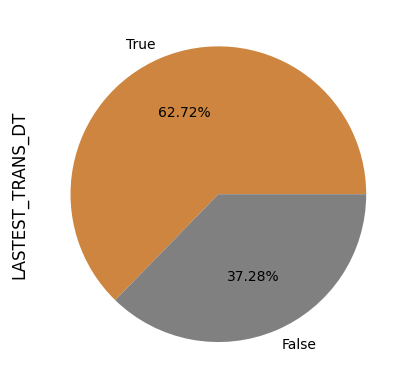

In [ ]:
tmp['LASTEST_TRANS_DT'].notnull().value_counts().plot(kind='pie', autopct='%.2f%%', colors=['peru','gray'])

In [ ]:
tmp['LASTEST_TRANS_DT'].fillna(min_latest_txn,inplace=True)

In [ ]:
tmp = tmp[tmp['LASTEST_TRANS_DT'].notnull()]

In [ ]:
tmp = tmp[['LASTEST_TRANS_DT', 'CUSTOMER_CDE', 'CUST_STATUS']].set_index('LASTEST_TRANS_DT').sort_index()

In [ ]:
tmp1 = (tmp.reset_index().groupby([pd.Grouper(key='LASTEST_TRANS_DT', axis=0,freq='2M', sort=True), 'CUST_STATUS'])['CUSTOMER_CDE'].nunique() / len(tmp)).to_frame('prop').reset_index()

In [ ]:
tmp1 = tmp1.sort_values(by=['LASTEST_TRANS_DT', 'CUST_STATUS'])

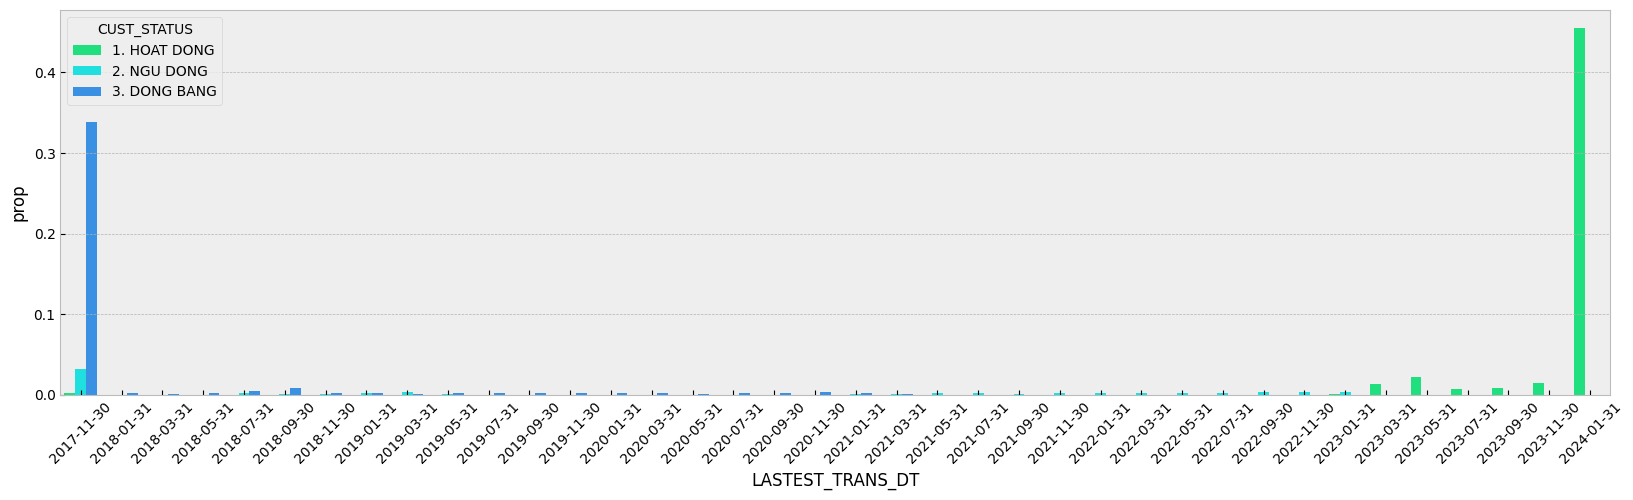

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp1, x='LASTEST_TRANS_DT', y='prop', hue='CUST_STATUS', 
                 palette=['springgreen', 'cyan', 'dodgerblue'], 
                 hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
tmp2 = tmp1[(tmp1['LASTEST_TRANS_DT'] <=pd.Timestamp('2023-10-31')) & (tmp1['LASTEST_TRANS_DT'] >=pd.Timestamp('2018-01-30'))]

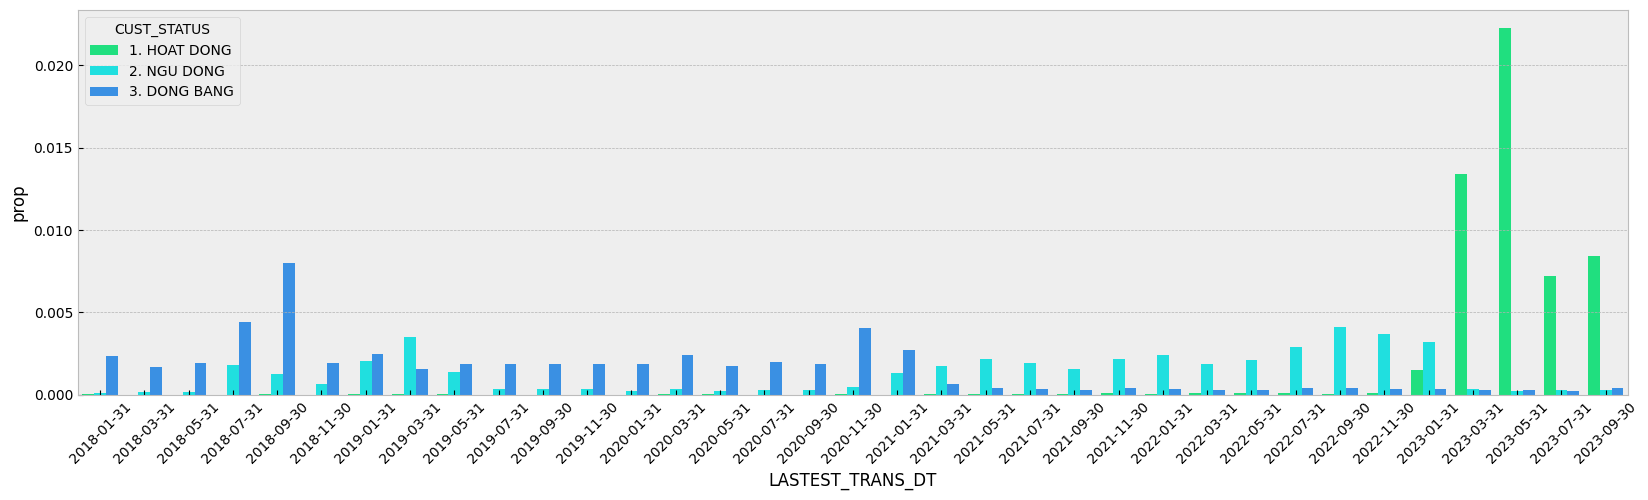

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax = sns.barplot(tmp2, x='LASTEST_TRANS_DT', y='prop', hue='CUST_STATUS', 
                 palette=['springgreen', 'cyan', 'dodgerblue'], 
                 hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'],
                )
ax.tick_params(axis='x', rotation=45)
plt.show()

# DEMOGRAPHIC

## PROVINCE_NM

In [ ]:
tmp = df3.copy()

In [ ]:
top5_ct = tmp['PROVINCE_NM'].value_counts(dropna=False)[:5].index
# .plot(kind='pie', autopct='%.2f%%')

In [ ]:
tmp['PROVINCE_NM'] = tmp['PROVINCE_NM'].apply(lambda x: 'OTHER' if x not in top5_ct else x)

<Axes: ylabel='PROVINCE_NM'>

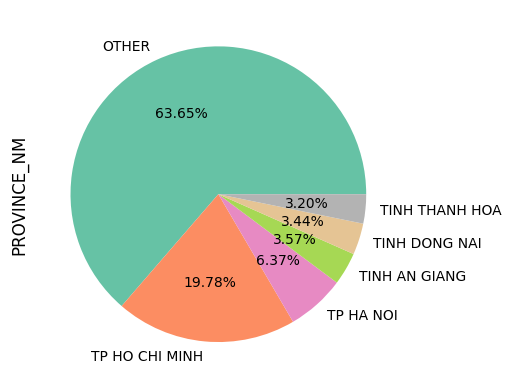

In [ ]:
tmp['PROVINCE_NM'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='Set2')

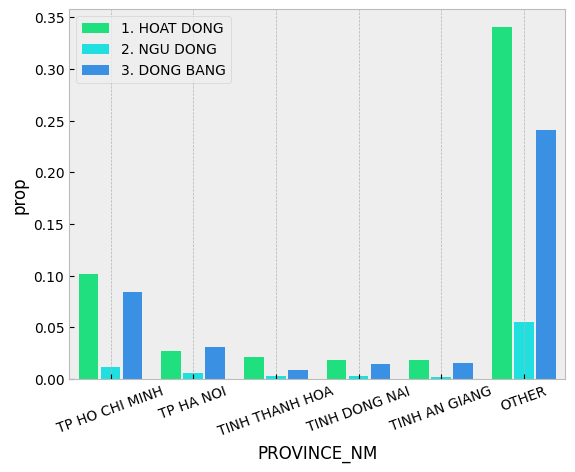

In [ ]:
datap = (tmp.groupby('PROVINCE_NM')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index()[::-1].to_frame('prop').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='PROVINCE_NM', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

In [ ]:
pct = pd.crosstab(tmp['PROVINCE_NM'], tmp['CUST_STATUS'], normalize='index').round(2)[::-1]

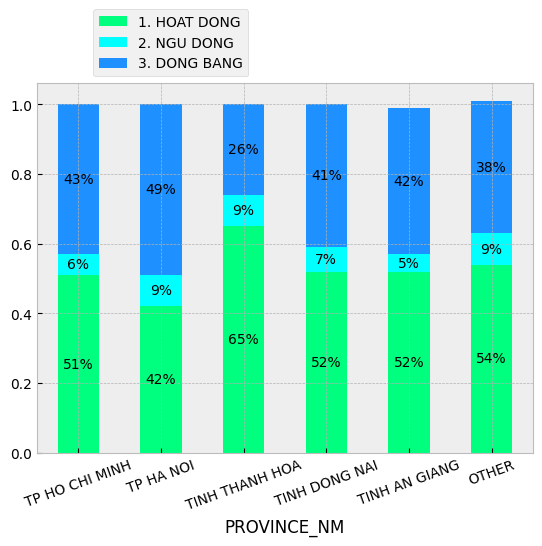

In [ ]:
ax = pct.plot(kind='bar', stacked=True, color=[ 'springgreen','cyan', 'dodgerblue'],
              # index=['TP HO CHI MINH', 'TP HA NOI', 'TINH THANH HOA', 'TINH DONG NAI', 'TINH AN GIANG','OTHER']
             )
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', 
          bbox_to_anchor=(0.1,1), 
          labels=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'])
for c in ax.containers:
    labels = [f'{w:.0f}%' if (w:=v.get_height()*100) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.show()

## BIRTHDAY

In [ ]:
tmp = df3.copy()

In [ ]:
col = 'BIRTHDAY'

In [ ]:
tmp['BIRTHDAY'].isna().sum()

0

In [ ]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [ ]:
tmp[tmp[col] <= '1923-01-01'].shape[0], tmp[tmp[col] <= '1923-01-01'].shape[0] / len(tmp) * 100

(1786, 0.36795836672634485)

In [ ]:
tmp['BIRTHDAY'].min(), tmp['BIRTHDAY'].max(), 

(Timestamp('1690-01-01 00:00:00'), Timestamp('2023-10-23 00:00:00'))

In [ ]:
tmp = tmp[tmp[col] > '1923-01-01']
tmp1 = tmp.set_index('BIRTHDAY')
# tmp1

In [ ]:
tmp1.index.min(), tmp1.index.max()

(Timestamp('1923-03-20 00:00:00'), Timestamp('2023-10-23 00:00:00'))

In [ ]:
data = tmp1.resample('5Y')['CUSTOMER_CDE'].nunique().to_frame('count').reset_index()
data['pct'] = data['count']/data['count'].sum()

<Axes: xlabel='BIRTHDAY'>

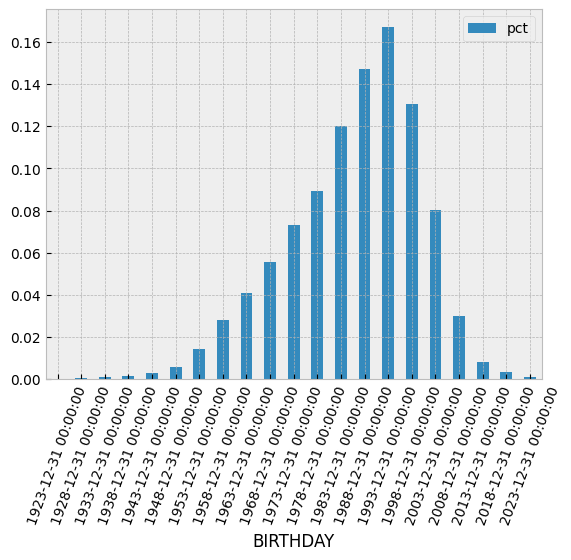

In [ ]:
data[['BIRTHDAY', 'pct']].set_index('BIRTHDAY').plot(kind='bar', rot=70)

In [ ]:
tmp2 = data[['BIRTHDAY', 'pct']].set_index('BIRTHDAY')
tmp2[(tmp2.index >= '1968-01-01') & (tmp2.index < '1998-01-01')]['pct'].sum()

0.6521761607672758

In [ ]:
data = tmp1.resample('1Y')['CUST_STATUS'].value_counts(normalize=False) 
data = data.to_frame('count').reset_index()
data['density'] = data['count']/data['count'].sum()

<Axes: xlabel='BIRTHDAY', ylabel='density'>

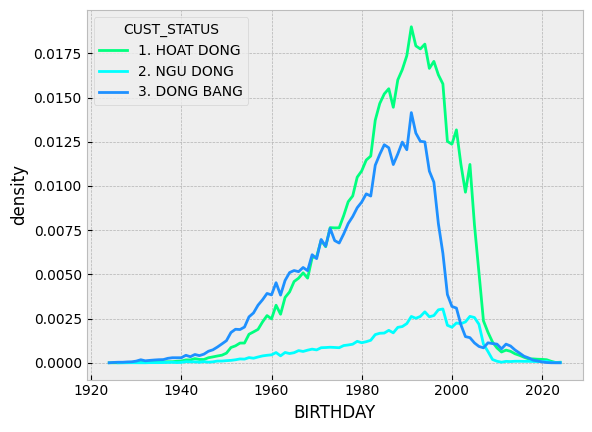

In [ ]:
sns.lineplot(data,x='BIRTHDAY',y='density',hue='CUST_STATUS', palette=['springgreen','cyan', 'dodgerblue', ], hue_order=['1. HOAT DONG','2. NGU DONG', '3. DONG BANG'])

In [ ]:
groupby_col = 'BIRTHDAY'

In [ ]:
# data = tmp1.groupby(groupby_col)['CUST_STATUS'].value_counts()
data = tmp1.resample('5Y')['CUST_STATUS'].value_counts(normalize=False) 
# data

In [ ]:
data = data.to_frame('count').reset_index()

In [ ]:
res = data.pivot_table(index=groupby_col, columns='CUST_STATUS', values='count',fill_value=0)

In [ ]:
res = res.apply(lambda x: x/x.sum(), axis=1)

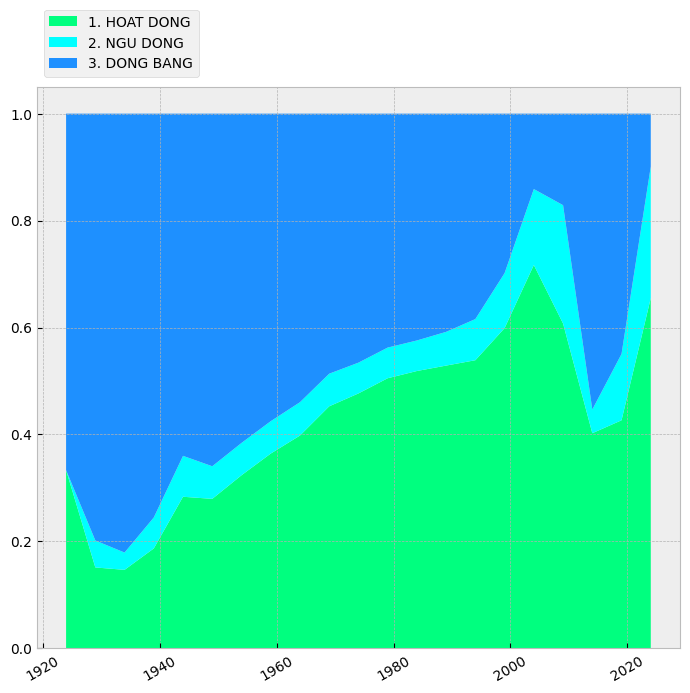

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=[ 'springgreen','cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

## AGE & GEN

In [ ]:
def bin_age_group(x):
    if x < 18:
        return '1. Under 18'
    elif x < 22:
        return '2. From 18 to 22'
    elif x < 25:
        return '3. From 22 to 25'
    elif x < 30:
        return '4. From 25 to 30'
    elif x < 35:
        return '5. From 30 to 35'
    elif x < 45:
        return '6. From 35 to 45'
    elif x < 65:
        return '7. From 45 to 65'
    else:
        return '8. Over 65'

In [ ]:
def bin_gen_group(x):
    if x < pd.Timestamp('1965-01-01'):
        return '5. Before Gen X'
    elif x < pd.Timestamp('1981-01-01'):
        return '4. Gen X'
    elif x < pd.Timestamp('1997-01-01'):
        return '3. Gen Y'
    elif x < pd.Timestamp('2012-01-01'):
        return '2. Gen Z'
    else:
        return '1. Gen A'

In [ ]:
tmp = df3.copy()

In [ ]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [ ]:
tmp = tmp[tmp[col] > '1923-01-01']
# tmp1 = tmp.set_index('BIRTHDAY')
# tmp1

In [ ]:
age = ((datetime(2024,1,1) - tmp['BIRTHDAY']) / pd.Timedelta('365.25 days'))

In [ ]:
tmp['AGE'] = age
tmp['AGE_GROUP'] = age.apply(lambda x:bin_age_group(x))
tmp['GEN_GROUP'] = tmp['BIRTHDAY'].apply(lambda x:bin_gen_group(x))

<Axes: xlabel='AGE', ylabel='Density'>

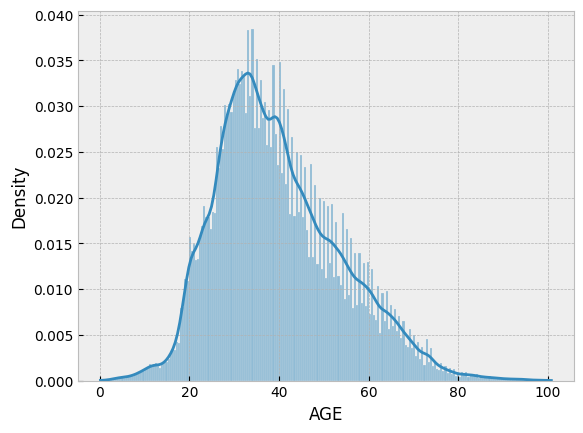

In [ ]:
sns.histplot(tmp['AGE'], kde=True,stat='density', common_norm=False)

<Axes: xlabel='AGE', ylabel='Density'>

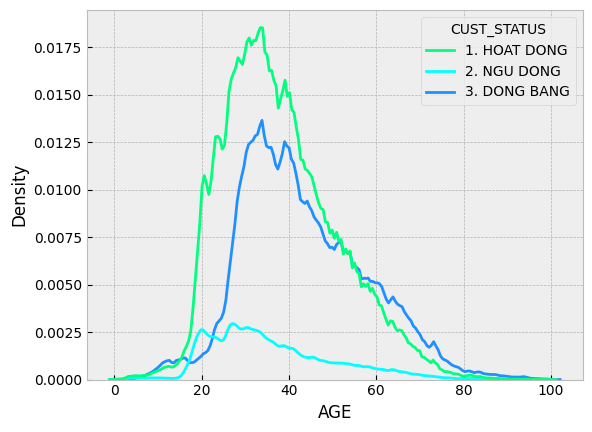

In [ ]:
sns.kdeplot(tmp,x='AGE', hue='CUST_STATUS', palette=['springgreen','cyan', 'dodgerblue', ], hue_order=['1. HOAT DONG','2. NGU DONG', '3. DONG BANG'], bw_adjust=.35)

### AGE GROUP

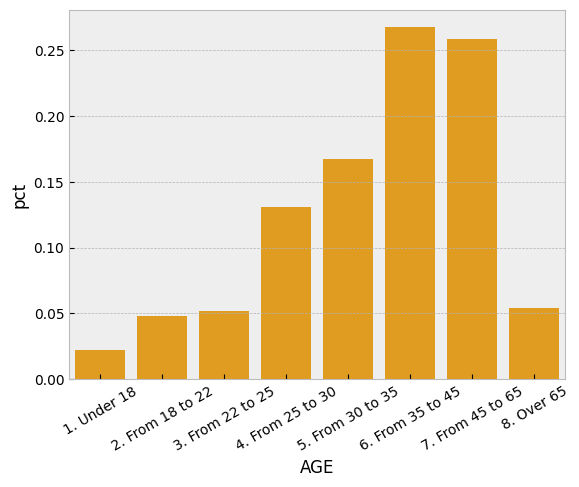

In [ ]:
tmp1 = tmp['AGE_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['AGE', 'pct']
ax = sns.barplot(tmp1, x='AGE', y='pct', color='orange')
ax.tick_params(axis='x', rotation=30)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), labels=[''])

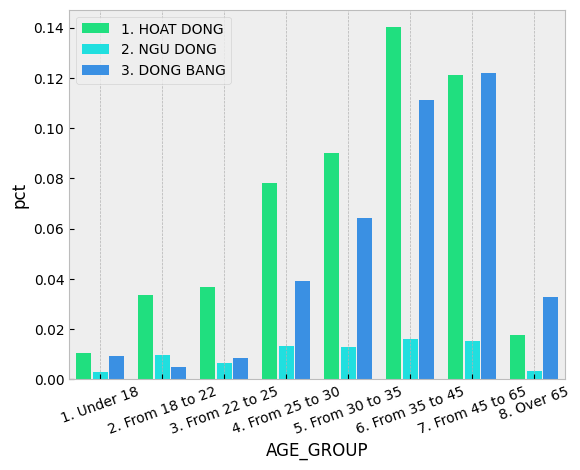

In [ ]:
datap = (tmp.groupby('AGE_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='AGE_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

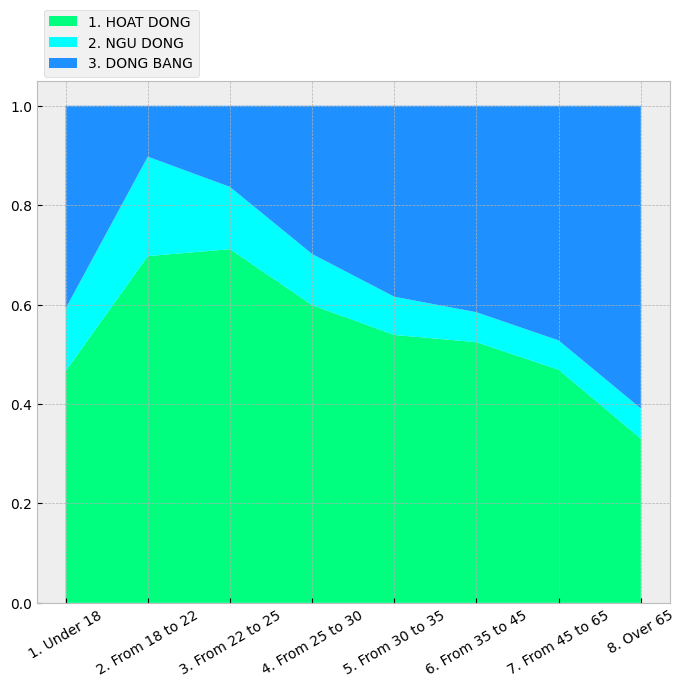

In [ ]:
data = tmp[:]

data = data.groupby('AGE_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

res = data.pivot_table(index='AGE_GROUP', columns='CUST_STATUS', values='count',fill_value=0)

res = res.apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen', 'cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

### GEN

<Axes: xlabel='GEN', ylabel='count'>

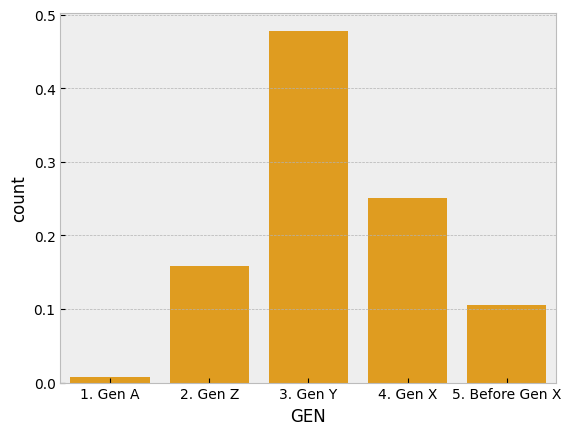

In [ ]:
tmp1 = tmp['GEN_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['GEN', 'count']
sns.barplot(tmp1, x='GEN', y='count', color='orange')

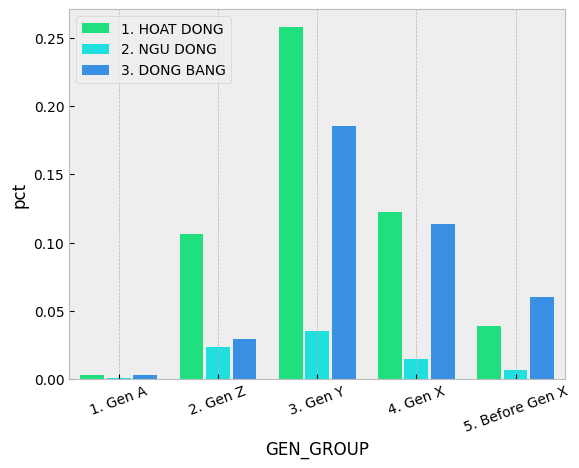

In [ ]:
datap = (tmp.groupby('GEN_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='GEN_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

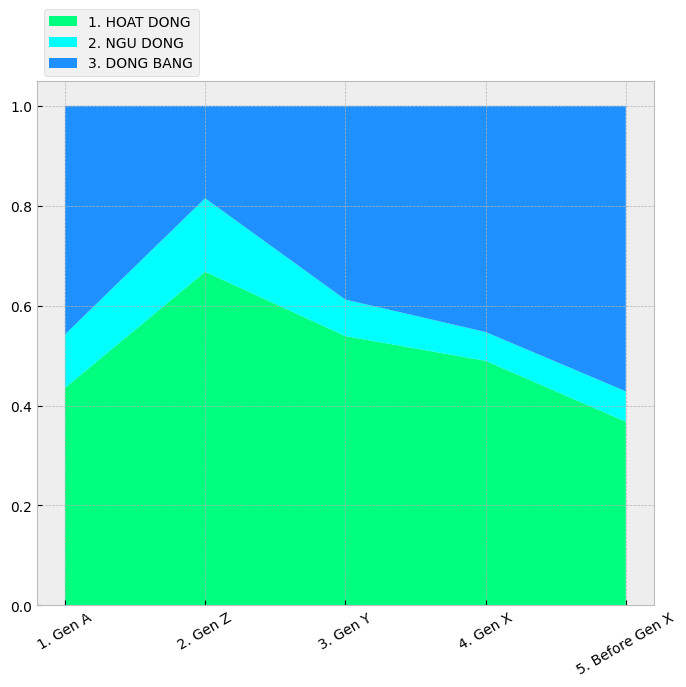

In [ ]:
data = tmp[:]

data = data.groupby('GEN_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

res = data.pivot_table(index='GEN_GROUP', columns='CUST_STATUS', values='count',fill_value=0)

res = res.apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen', 'cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
plt.tight_layout()
plt.show()

In [ ]:
data = tmp[:]

In [ ]:
groupby_col = 'GEN_GROUP'

In [ ]:
data = data.groupby(groupby_col)['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()

In [ ]:
res = data.pivot_table(index=groupby_col, columns='CUST_STATUS', values='count',fill_value=0)

In [ ]:
res = res.apply(lambda x: x/x.sum(), axis=1)

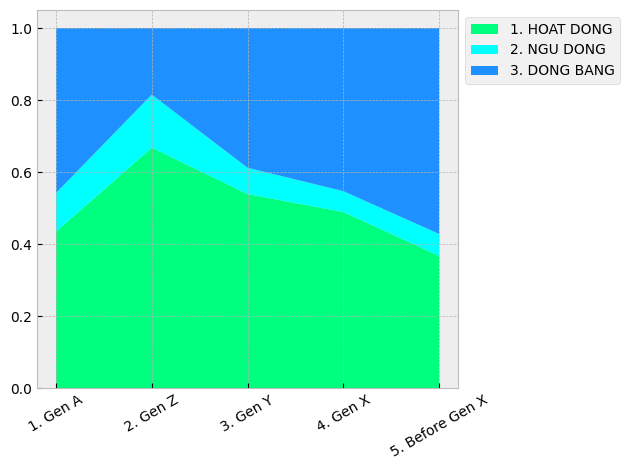

In [ ]:
fig, ax = plt.subplots(1,1)
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen', 'cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

## GENDER

In [ ]:
tmp = df3.copy()

In [ ]:
tmp['GENDER_CDE'].unique()

array(['MALE', 'FEMALE', ' '], dtype=object)

In [ ]:
def clean_gender(x):
    if x == 'M':
        return 'MALE'
    elif x == 'F':
        return 'FEMALE'
    elif x.strip() == '':
        return 'N/A'
    return x

In [ ]:
tmp['GENDER_CDE'] = tmp['GENDER_CDE'].apply(lambda x: clean_gender(x))

<Axes: ylabel='GENDER_CDE'>

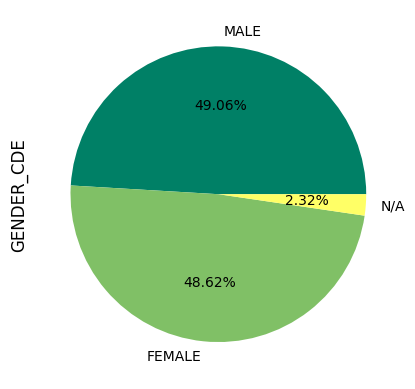

In [ ]:
tmp['GENDER_CDE'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='summer')

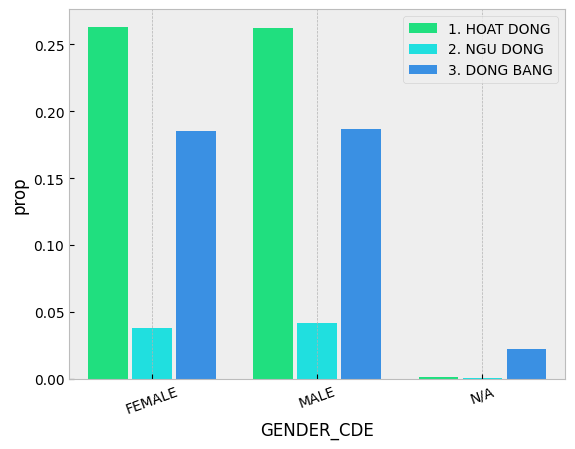

In [ ]:
datap = (tmp.groupby('GENDER_CDE')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('prop').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='GENDER_CDE', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [ ]:
df3.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS',
       'GENDER_CDE', 'PROVINCE_NM', 'CUS_OPEN_DT', 'DB_GRP_CIC'],
      dtype='object')

## MATRIMONY

In [ ]:
tmp = df3.copy()

In [ ]:
tmp['MATRIMONY_STATUS'].unique()

array(['MARRIED', 'SINGLE', ' ', 'DIVORCED', 'OTHER', 'PARTNER',
       'WIDOWED'], dtype=object)

In [ ]:
tmp['MATRIMONY_STATUS'].value_counts(dropna=False)

            225418
MARRIED     175508
SINGLE       84022
OTHER          370
DIVORCED        43
PARTNER         18
WIDOWED          2
Name: MATRIMONY_STATUS, dtype: int64

In [ ]:
def clean_matrimony(x):
    if x == 'S':
        return 'SINGLE'
    elif x == 'M':
        return 'MARRIED'
    elif (type(x) == str) and (x.strip() == ''):
        return 'N/A'
    elif x is None:
        return 'N/A'
    elif (x == 'W') or (x=='WIDOWED') or (x=='PARTNER'):
        return 'OTHER'
    elif (x == 'D') or (x == 'DIVORCED'):
        return 'OTHER'
    return x

In [ ]:
tmp['MATRIMONY_STATUS'] = tmp['MATRIMONY_STATUS'].apply(lambda x: clean_matrimony(x))

In [ ]:
tmp['MATRIMONY_STATUS'].value_counts(dropna=False)

N/A        225418
MARRIED    175508
SINGLE      84022
OTHER         433
Name: MATRIMONY_STATUS, dtype: int64

<Axes: ylabel='MATRIMONY_STATUS'>

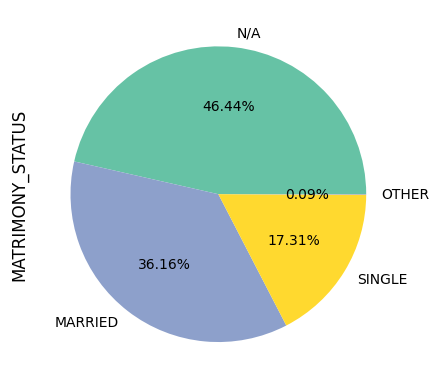

In [ ]:
tmp['MATRIMONY_STATUS'].value_counts().plot(kind='pie', autopct='%.2f%%', cmap='Set2')

In [ ]:
datap = (tmp.groupby('MATRIMONY_STATUS')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index()[::-1].to_frame('prop').reset_index()
# datap

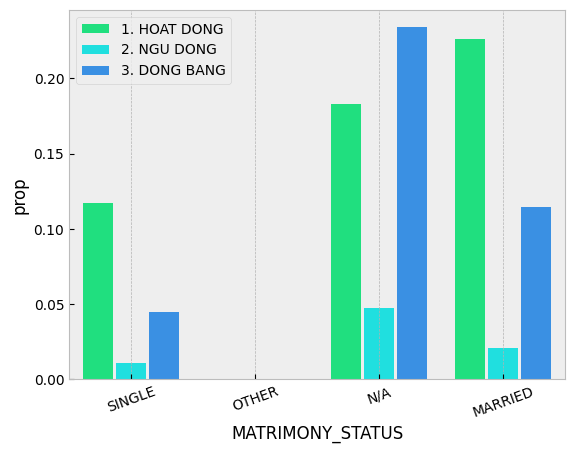

In [ ]:
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='MATRIMONY_STATUS', y='prop', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

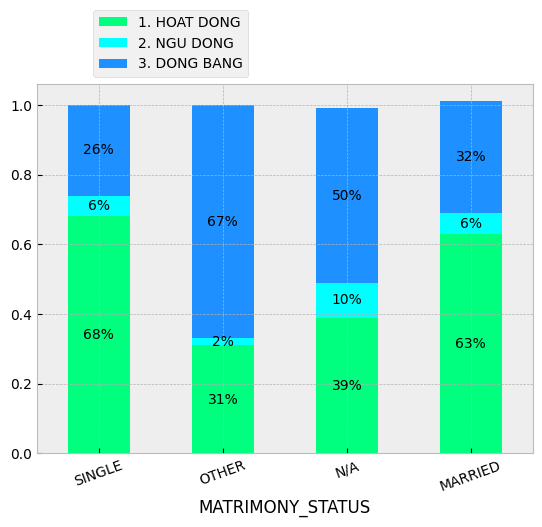

In [ ]:
pct = pd.crosstab(tmp['MATRIMONY_STATUS'], tmp['CUST_STATUS'], normalize='index').round(2)[::-1]

ax = pct.plot(kind='bar', stacked=True, color=[ 'springgreen','cyan', 'dodgerblue'],
              # index=['TP HO CHI MINH', 'TP HA NOI', 'TINH THANH HOA', 'TINH DONG NAI', 'TINH AN GIANG','OTHER']
             )
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', 
          bbox_to_anchor=(0.1,1), 
          labels=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'])
for c in ax.containers:
    labels = [f'{w:.0f}%' if (w:=v.get_height()*100) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.show()

# RELATIONSHIP WITH BANK

## RATE_LEVEL_NAME

In [ ]:
tmp = df3.copy()

<Axes: >

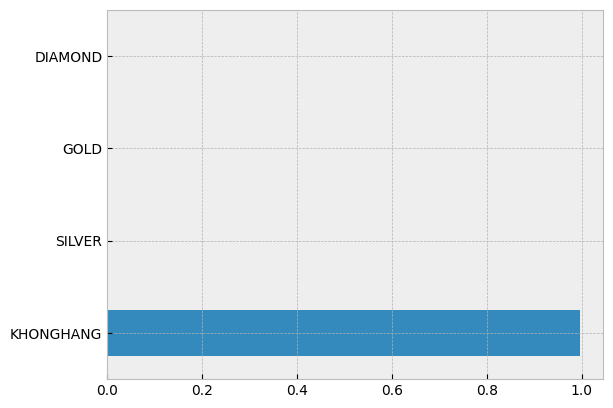

In [ ]:
(tmp['RATE_LEVEL_NAME'].apply(lambda x:x.upper()).value_counts(normalize=True)).plot(kind='barh')

## CUS_OPEN_DT

In [ ]:
df3 = df2_1.merge(df1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
tmp = df3.copy()

In [ ]:
col = 'CUS_OPEN_DT'

In [ ]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [ ]:
tmp['CUS_OPEN_DT'].isna().sum()

38

In [ ]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [ ]:
# tmp[tmp[col] <= '1923-01-01'].shape[0], tmp[tmp[col] <= '1923-01-01'].shape[0] / len(tmp) * 100

In [ ]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2024-01-06 03:01:00'))

<Axes: xlabel='CUS_OPEN_DT'>

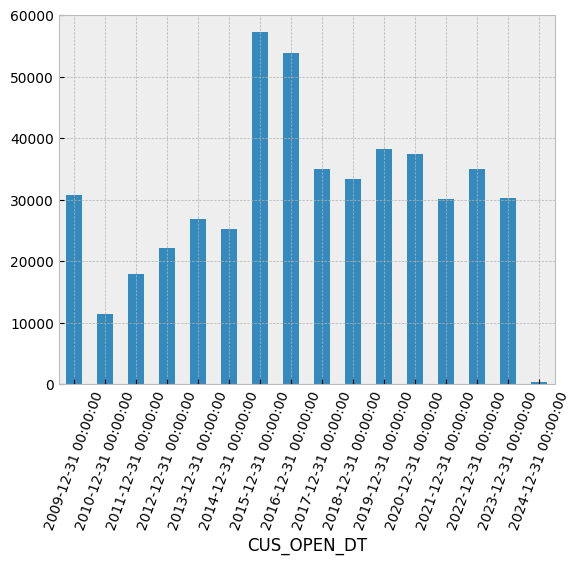

In [ ]:
tmp.set_index(col)['CUSTOMER_CDE'].resample('1Y').nunique().plot(kind='bar', rot=70)

In [ ]:
tmp = df3.copy()

In [ ]:
tmp['CUS_OPEN_DT'].isna().sum()

38

In [ ]:
tmp = tmp[~tmp['CUS_OPEN_DT'].isna()]

In [ ]:
tmp['CUS_OPEN_DT'].isna().sum()

0

In [ ]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2024-01-06 03:01:00'))

In [ ]:
tmp[col] = pd.to_datetime(tmp[col], errors='coerce')
tmp[col] = tmp[col].astype('datetime64[D]')

In [ ]:
rel = ((datetime(2024,1,1) - tmp['CUS_OPEN_DT']) / pd.Timedelta('365.25 days'))

Text(0.5, 1.0, 'Relationship Year')

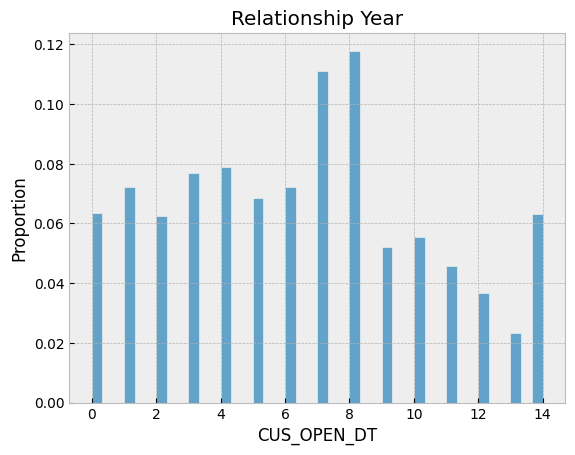

In [ ]:
sns.histplot(rel.apply(int), bins=42,stat='proportion')
plt.title('Relationship Year')

### REL YEAR & AGE

In [ ]:
tmp = df3.copy()

In [ ]:
tmp = tmp[~tmp['CUS_OPEN_DT'].isna()]

In [ ]:
tmp['CUS_OPEN_DT'].min(), tmp['CUS_OPEN_DT'].max(), 

(Timestamp('2009-06-04 00:00:00'), Timestamp('2024-01-06 03:01:00'))

In [ ]:
tmp = tmp[['CUST_STATUS', 'BIRTHDAY', 'CUST_OPEN_DT']]
tmp = tmp[tmp['BIRTHDAY']>=pd.Timestamp('1924-01-01')]
tmp['BIRTHDAY'] = pd.to_datetime(tmp['BIRTHDAY'], errors='coerce').astype('datetime64[D]')
tmp['CUST_OPEN_DT'] = pd.to_datetime(tmp['CUST_OPEN_DT'], errors='coerce').astype('datetime64[D]')
tmp['AGE'] = ((datetime(2024,1,1) - tmp['BIRTHDAY']) / pd.Timedelta('365.25 days'))
tmp['REL_YEAR'] = ((datetime(2024,1,1) - tmp['CUST_OPEN_DT']) / pd.Timedelta('365.25 days'))
tmp = tmp[tmp['REL_YEAR']<=14]
tmp = tmp[tmp['AGE']<80]
tmp = tmp.sample(frac=0.5)
tmp = tmp.sort_values(by='CUST_STATUS')
len(tmp)

225396

In [ ]:
# This take long

In [ ]:
# g = sns.jointplot(tmp, x='AGE', y='REL_YEAR', hue='CUST_STATUS', kind='kde',levels=100, linewidths=1, palette=[ 'springgreen','cyan', 'dodgerblue'], 
#                   fill=True, alpha=0.5, legend=False,)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR', levels=4,linewidths=1.5, color='orange', legend=False, ax=g.ax_joint)

In [ ]:
# This take long

In [ ]:
# sns.displot(tmp, x='AGE', y='REL_YEAR', kind='kde', col='CUST_STATUS',levels=10,fill=True,hue='CUST_STATUS',palette=[ 'springgreen','cyan', 'dodgerblue'])

In [ ]:
# Additional Charts

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(7,7))
# sns.scatterplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS', s=1,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax)
# # sns.histplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS', bins=50, pthresh=.05,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax, alpha=0.85)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS',levels=3, linewidths=1,palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax)
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',levels=3, linewidths=1.5,color='orange',ax=ax, )
# # ax.grid(False)
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(7,7))
# sns.kdeplot(tmp, x='AGE', y='REL_YEAR',hue='CUST_STATUS',palette=[ 'springgreen','cyan', 'dodgerblue'],ax=ax, fill=True, alpha=0.5)
# plt.show()

### REL_GROUP

In [ ]:
tmp = df3.copy()

In [ ]:
def bin_rel_group(x):
    if x < 1:
        return '1. Less 1 year'
    elif x < 3:
        return '2. From 1 to 3 year'
    elif x < 5:
        return '3. From 3 to 5 year'
    elif x < 10:
        return '4. From 5 to 10 year'
    else:
        return '5. Over 10 year'

In [ ]:
tmp['REL_GROUP'] = rel.apply(lambda x: bin_rel_group(x))

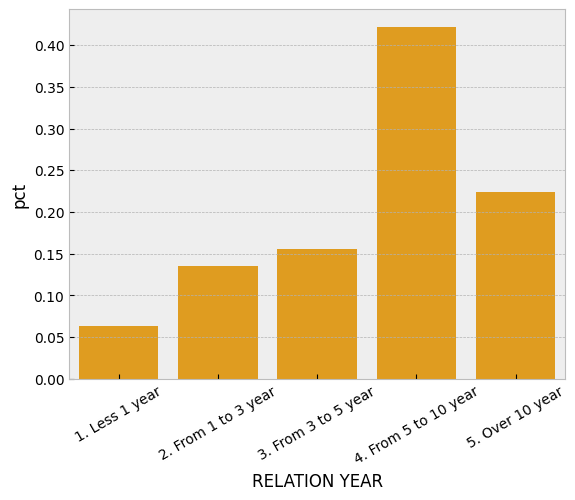

In [ ]:
tmp1 = tmp['REL_GROUP'].value_counts(normalize=True).sort_index().reset_index()
tmp1.columns = ['RELATION YEAR', 'pct']
ax = sns.barplot(tmp1, x='RELATION YEAR', y='pct', color='orange')
ax.tick_params(axis='x', rotation=30)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), labels=[''])

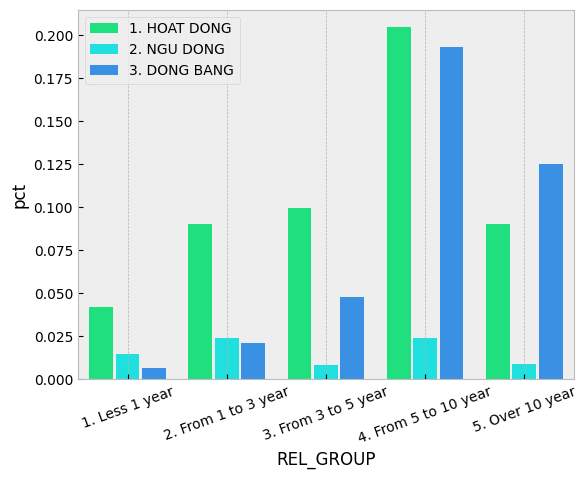

In [ ]:
datap = (tmp.groupby('REL_GROUP')['CUST_STATUS'].value_counts(normalize=False)/len(tmp)).sort_index().to_frame('pct').reset_index()
datap
fig,ax=plt.subplots(1,1)
sns.barplot(datap, x='REL_GROUP', y='pct', hue='CUST_STATUS', ax=ax, 
            hue_order=['1. HOAT DONG', '2. NGU DONG', '3. DONG BANG'], 
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper left', )
plt.grid()
plt.show()

In [ ]:
data = tmp
data = data.groupby('REL_GROUP')['CUST_STATUS'].value_counts()
data = data.to_frame('count').reset_index()
res = data.pivot_table(index='REL_GROUP', columns='CUST_STATUS', values='count',fill_value=0)
res = res.apply(lambda x: x/x.sum(), axis=1)

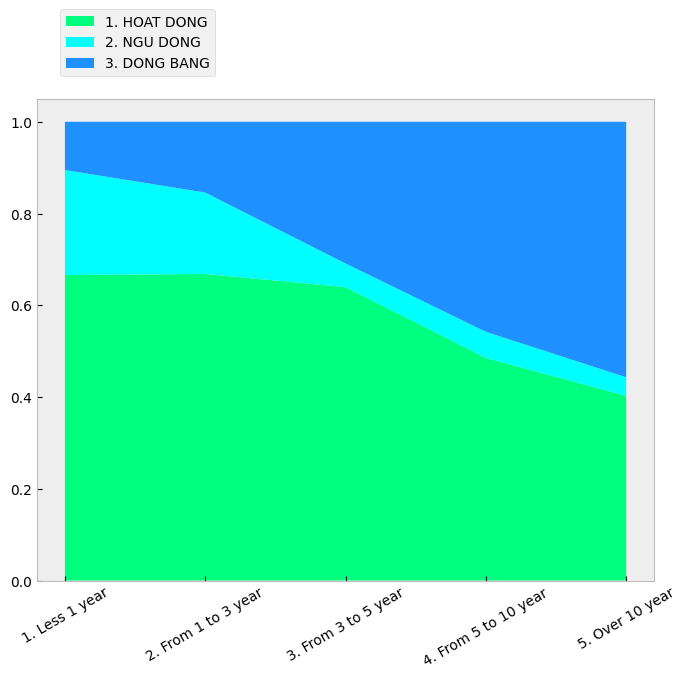

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.stackplot(res.index.tolist(), res.values.T, labels=res.columns.tolist(), colors=['springgreen','cyan', 'dodgerblue'])
ax.tick_params(axis='x', rotation=30)
ax.legend(loc='best', bbox_to_anchor=(0.3,1.2))
ax.grid()
plt.tight_layout()
plt.show()

# FINANCE

In [ ]:
df4 = df3.merge(credit_data, how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
df4.columns

Index(['PROCESS_DT', 'CUSTOMER_CDE', 'CUST_TYPE', 'CUST_STATUS', 'BH', 'IB',
       'MB', 'PAY', 'TKTT', 'TK', 'VAY', 'DEBIT', 'MD', 'LC', 'FX', 'TTQT',
       'SP_KHAC', 'SD_BH', 'SD_IB', 'SD_MB', 'SD_PAY', 'SD_TKTT', 'SD_TK',
       'SD_VAY', 'SD_MD', 'SD_LC', 'SD_FX', 'SD_TTQT', 'CREDIT', 'PREPAID',
       'SD_CREDIT', 'SD_PREPAID', 'PAYROLL', 'SD_PAYROLL', 'SD_SP_KHAC',
       'OS_AMT_LCL', 'ACTUAL_AMT_LCL', 'LASTEST_TRANS_DT', 'REC_CREATE_DT',
       'CUST_OPEN_DT', 'RATE_LEVEL_NAME', 'BIRTHDAY', 'MATRIMONY_STATUS',
       'GENDER_CDE', 'PROVINCE_NM', 'CUS_OPEN_DT', 'DB_GRP_CIC',
       'CREDIT_SCORE'],
      dtype='object')

## DEBIT_GROUP

In [ ]:
tmp = df4.copy()

In [ ]:
tmp['DB_GRP_CIC'].value_counts(dropna=False, normalize=True)

None      0.998560
NHOM 2    0.000709
NHOM 4    0.000319
NHOM 3    0.000286
NHOM 5    0.000126
Name: DB_GRP_CIC, dtype: float64

In [ ]:
463/len(tmp) * 100

0.09538898308751269

<Axes: ylabel='DB_GRP_CIC'>

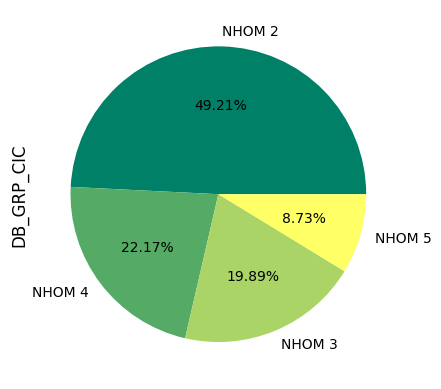

In [ ]:
tmp[~tmp['DB_GRP_CIC'].isnull()]['DB_GRP_CIC'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%', cmap='summer')

## CREDIT SCORE

In [ ]:
tmp = df4.copy()

In [ ]:
tmp['CREDIT_SCORE'].isna().sum(), tmp['CREDIT_SCORE'].isna().sum()/len(tmp) * 100

(476258, 98.12044558810501)

In [ ]:
(~tmp['CREDIT_SCORE'].isna()).sum(), (~tmp['CREDIT_SCORE'].isna()).sum()/len(tmp) * 100

(9123, 1.8795544118949854)

<Axes: xlabel='CREDIT_SCORE', ylabel='Proportion'>

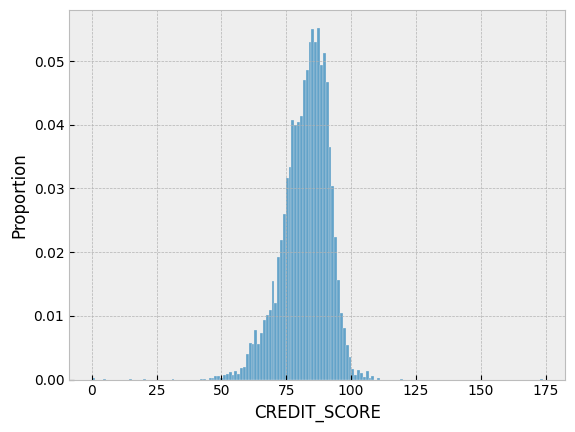

In [ ]:
sns.histplot(tmp['CREDIT_SCORE'], stat='proportion')

In [ ]:
tmp1 = tmp[['DB_GRP_CIC', 'CREDIT_SCORE', 'CUST_STATUS']]
tmp1 = tmp1[tmp1['CREDIT_SCORE'].notnull()]
tmp1['DB_GRP_CIC'].fillna('N/A',inplace=True)

In [ ]:
tmp1 = tmp1.sort_values(by=['CUST_STATUS', 'CREDIT_SCORE'])

In [ ]:
pal = sns.color_palette("flare")

In [ ]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,ha='left', va='center', transform=ax.transAxes)

In [ ]:
sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

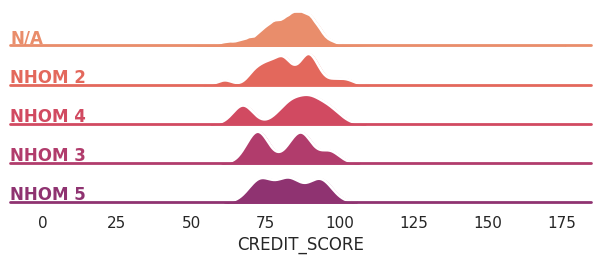

In [ ]:
g = sns.FacetGrid(tmp1, row='DB_GRP_CIC', hue='DB_GRP_CIC', aspect=15, height=0.5, palette=pal)
g.map(sns.kdeplot,'CREDIT_SCORE', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot,'CREDIT_SCORE',clip_on=False,color='w', lw=2,bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle='-',color=None, clip_on=False)
g.map(label,'CREDIT_SCORE')
g.figure.subplots_adjust(hspace=0.1)
g.set_titles("")
g.set(yticks=[],ylabel="")
g.despine(bottom=True, left=True)

# BANK PRODUCTS

In [ ]:
# sns.reset_defaults()
plt.style.use('bmh')

## TKTT

In [ ]:
tmp = df2_1.copy()

In [ ]:
tmp['CUSTOMER_CDE'].nunique()

485381

In [ ]:
tmp['PROCESS_DT'].unique()

array(['2024-01-07T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
tmp['SD_TKTT'] = tmp['SD_TKTT'].fillna(0)

In [ ]:
tmp['TKTT'] = tmp['TKTT'].fillna(0)

<Axes: ylabel='SD_TKTT'>

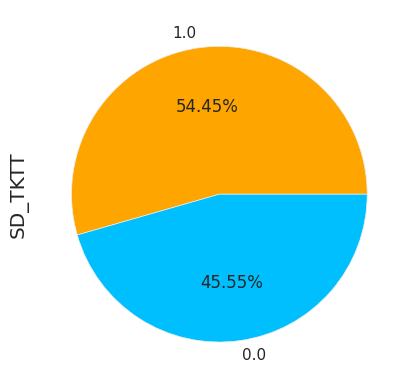

In [ ]:
tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])

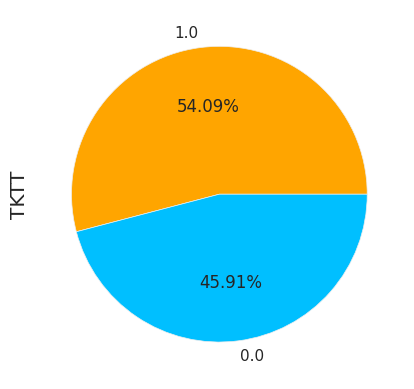

In [ ]:
tmp['TKTT'].value_counts(dropna=False).loc[[1, 0]].plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])
plt.show()

In [ ]:
tmp1 = tmp[['SD_TKTT','CUST_STATUS']].value_counts(dropna=False, normalize=True)
tmp1 = tmp1.to_frame('prop').reset_index().sort_values(by=['SD_TKTT', 'CUST_STATUS'])

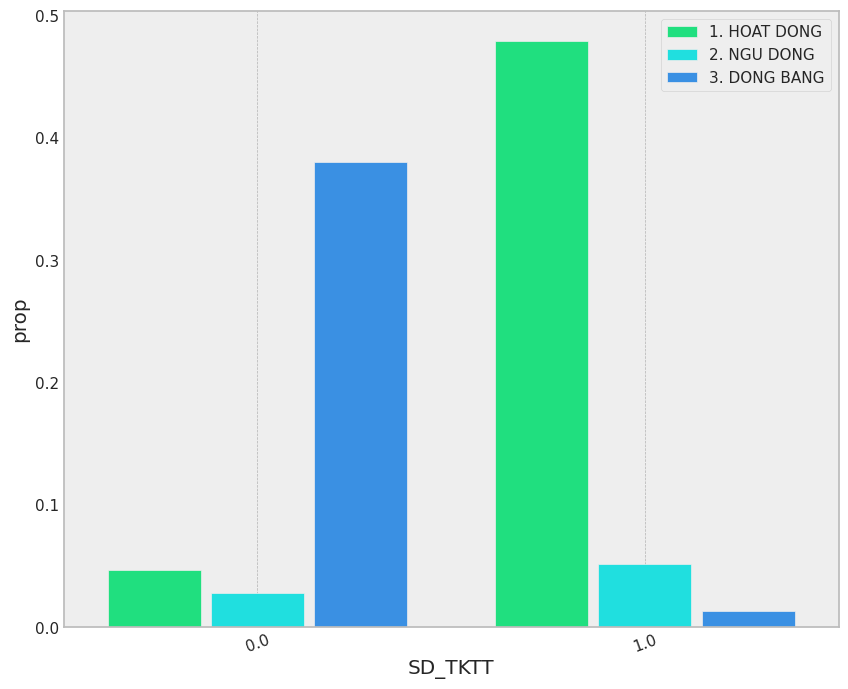

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.barplot(tmp1,x='SD_TKTT',hue='CUST_STATUS',y='prop',palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True,ax=ax)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [ ]:
tmp.groupby(['SD_TKTT','CUST_STATUS','TKTT'])['CUSTOMER_CDE'].nunique()

SD_TKTT  CUST_STATUS   TKTT
0.0      1. HOAT DONG  0.0      22848
         2. NGU DONG   0.0      13768
         3. DONG BANG  0.0     184486
1.0      1. HOAT DONG  0.0       1606
                       1.0     231171
         2. NGU DONG   0.0        144
                       1.0      24769
         3. DONG BANG  1.0       6589
Name: CUSTOMER_CDE, dtype: int64

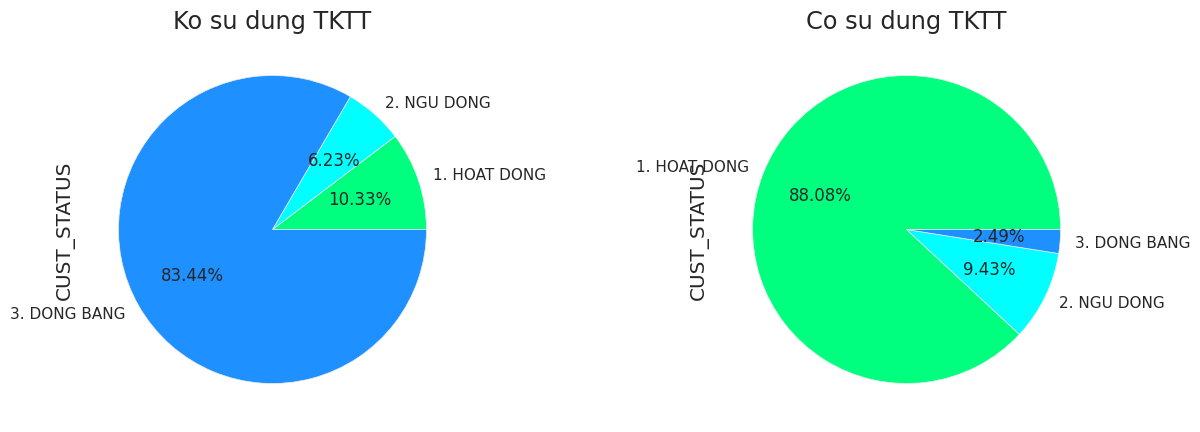

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tmp[tmp['SD_TKTT']==1]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[1], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
tmp[tmp['SD_TKTT']==0]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[0], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
axes[1].set_title('Co su dung TKTT')
axes[0].set_title('Ko su dung TKTT')
plt.show()

### DEPOSIT

In [ ]:
deposit_df = pd.read_pickle(DEPOSIT_FCT)

In [ ]:
deposit_df.columns

Index(['CUSTOMER_CDE', 'ACTUAL_BAL_LCL', 'PROCESS_DT', 'SUB_TERM_ID'], dtype='object')

In [ ]:
# Tong so record deposit transaction 
len(deposit_df)

15793729

In [ ]:
deposit_df

,CUSTOMER_CDE,ACTUAL_BAL_LCL,PROCESS_DT,SUB_TERM_ID
0,5309948,34637382.0,2023-08-01,NonTerm
1,12243882,783582.0,2023-08-01,NonTerm
2,13116539,860516.0,2023-08-01,NonTerm
3,13093070,1566403.0,2023-08-01,NonTerm
4,13094709,2942634.0,2023-08-01,NonTerm
...,...,...,...,...
15793724,11662770,-303600000.0,2023-05-31,NonTerm
15793725,11705626,1347319.0,2023-05-31,NonTerm
15793726,11632125,59254.0,2023-05-31,NonTerm
15793727,10928528,54889.0,2023-05-31,NonTerm


In [ ]:
deposit_df['SUB_TERM_ID'].value_counts(normalize=True)

NonTerm    0.859650
12M        0.048385
6M         0.034725
1M         0.021548
3M         0.011115
2M         0.004618
15M        0.003699
24M        0.003122
84M        0.002931
36M        0.002777
99M        0.001503
7M         0.001323
60M        0.000750
9M         0.000685
18M        0.000578
4M         0.000488
8M         0.000271
13M        0.000246
>10Y       0.000244
1W         0.000235
10M        0.000230
5M         0.000217
48M        0.000164
120M       0.000145
11M        0.000129
2W         0.000086
3W         0.000032
72M        0.000027
96M        0.000024
108M       0.000021
16M        0.000017
01M        0.000010
14M        0.000005
Name: SUB_TERM_ID, dtype: float64

In [ ]:
deposit_df['CUSTOMER_CDE'].nunique()

272290

In [ ]:
tmp = deposit_df[deposit_df['SUB_TERM_ID']=='NonTerm'].merge(df2_1[['CUSTOMER_CDE', 'CUST_STATUS', 'TKTT', 'SD_TKTT']], how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
tmp = tmp[tmp['ACTUAL_BAL_LCL'] > 0]

In [ ]:
len(tmp)

13144299

In [ ]:
tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(), tmp[['CUSTOMER_CDE', 'SD_TKTT']].drop_duplicates()['SD_TKTT'].value_counts(normalize=True)

(1.0    241589
 0.0      7703
 Name: SD_TKTT, dtype: int64,
 1.0    0.9691
 0.0    0.0309
 Name: SD_TKTT, dtype: float64)

In [ ]:
tmp.groupby('CUST_STATUS')['CUSTOMER_CDE'].nunique()

CUST_STATUS
1. HOAT DONG    233617
2. NGU DONG      15361
3. DONG BANG       406
Name: CUSTOMER_CDE, dtype: int64

In [ ]:
tmp[tmp['SD_TKTT']==1].groupby('CUST_STATUS')['CUSTOMER_CDE'].nunique()

CUST_STATUS
1. HOAT DONG    229580
2. NGU DONG      12005
3. DONG BANG         4
Name: CUSTOMER_CDE, dtype: int64

In [ ]:
tmp['ACTUAL_BAL_LCL'].isna().sum()

0

In [ ]:
tmp['ACTUAL_BAL_LCL'].describe()

count    1.314430e+07
mean     8.212442e+06
std      1.531355e+08
min      1.000000e+00
25%      5.000000e+04
50%      5.729300e+04
75%      3.648235e+05
max      2.373765e+11
Name: ACTUAL_BAL_LCL, dtype: float64

In [ ]:
tmp['ACTUAL_BAL_LCL'].apply(lambda x:np.log(x)).describe()

count    1.314430e+07
mean     1.149321e+01
std      2.866935e+00
min      0.000000e+00
25%      1.081978e+01
50%      1.095593e+01
75%      1.280717e+01
max      2.619291e+01
Name: ACTUAL_BAL_LCL, dtype: float64

In [ ]:
tmp.groupby('CUST_STATUS')['ACTUAL_BAL_LCL'].agg(['min','mean', 'median','max'])

,min,mean,median,max
CUST_STATUS,,,,
1. HOAT DONG,1.0,8.641594e+06,58899.0,2.373765e+11
2. NGU DONG,1.0,1.150836e+06,1028.0,2.900119e+10
3. DONG BANG,1.0,2.270186e+06,55818.5,4.416780e+08


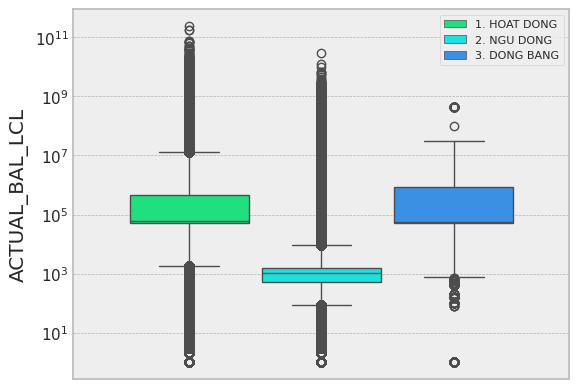

In [ ]:
ax = sns.boxplot(tmp, y='ACTUAL_BAL_LCL', 
                 log_scale=True, 
                 hue='CUST_STATUS', 
            # fill=False, 
            # notch=True, showcaps=False,
            # medianprops={'color':'r'},
            palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
                 # figsize=(7,7)
           )
ax.legend(prop={'size':8})

<Axes: xlabel='ACTUAL_BAL_LCL', ylabel='Density'>

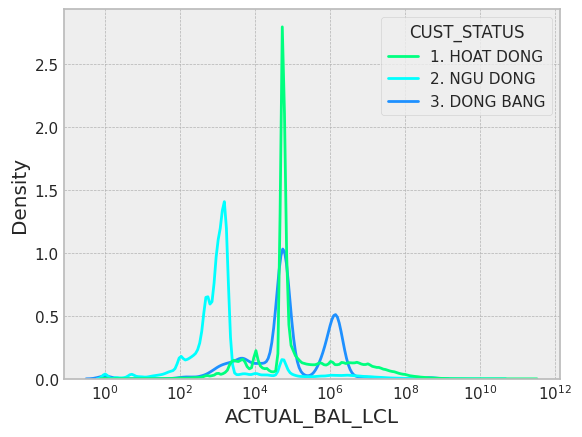

In [ ]:
sns.kdeplot(tmp, x='ACTUAL_BAL_LCL',
            log_scale=True, 
            # stat='proportion', 
            hue='CUST_STATUS', 
            # element='step',
            # fill=False, 
            # cumulative=True, 
            common_norm=False,
            palette=['springgreen', 'cyan', 'dodgerblue']
            )

In [ ]:
tmp1 = tmp.groupby(['TKTT','CUST_STATUS', 'CUSTOMER_CDE'])['ACTUAL_BAL_LCL'].sum().reset_index()
tmp1['ACTUAL_BAL_LCL'] = tmp1['ACTUAL_BAL_LCL'].apply(lambda x:np.log(x))

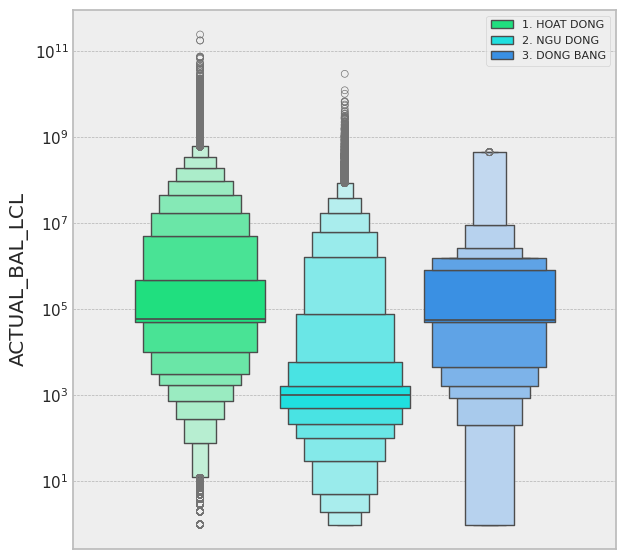

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxenplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL', width_method='linear',palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
              ax=ax,
              log_scale=True,
              k_depth='proportion', 
              # medianprops={'color':'r'},
             )
ax.legend(prop={'size':8})
plt.show()

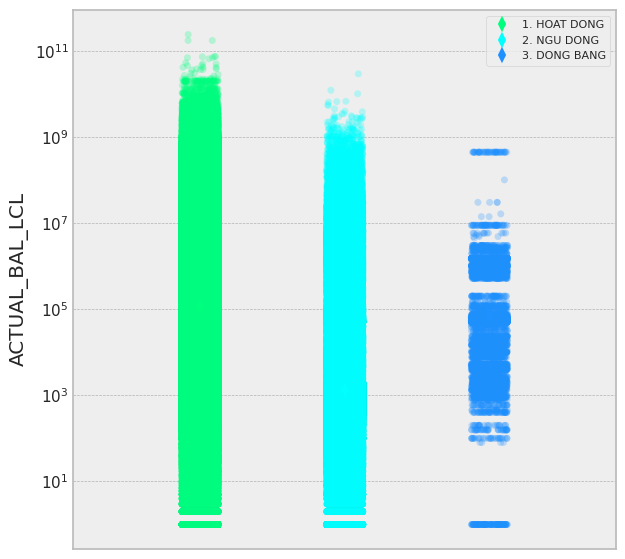

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.stripplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL', 
              dodge=True,
              # zorder=1,
              palette=['springgreen', 'cyan', 'dodgerblue'], 
              ax=ax,
              log_scale=True,
              alpha=.25,
              legend=False
             )
sns.pointplot(tmp, hue='CUST_STATUS', y='ACTUAL_BAL_LCL',
              dodge=.8 - .8/3, errorbar=None, 
              palette=['springgreen', 'cyan', 'dodgerblue'], 
              markers='d', markersize=4, linestyle='none'
             )
ax.legend(prop={'size':8})
plt.show()

### SUB_TERM

In [ ]:
tmp = deposit_df.copy()
tmp1 = cust_status.copy()

In [ ]:
tmp = tmp.merge(cust_status, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
tmp[tmp['SUB_TERM_ID']=='100M']['CUST_TYPE'].value_counts()

Series([], Name: CUST_TYPE, dtype: int64)

In [ ]:
tmp['SUB_TERM_ID'].value_counts(normalize=True)

NonTerm    0.859663
12M        0.048383
6M         0.034734
1M         0.021553
3M         0.011116
2M         0.004619
15M        0.003701
24M        0.003122
84M        0.002932
36M        0.002776
99M        0.001504
7M         0.001323
60M        0.000750
9M         0.000685
18M        0.000578
4M         0.000488
8M         0.000271
13M        0.000246
>10Y       0.000244
10M        0.000230
5M         0.000217
1W         0.000213
48M        0.000160
120M       0.000145
11M        0.000129
2W         0.000086
3W         0.000031
72M        0.000027
96M        0.000021
108M       0.000021
16M        0.000017
01M        0.000010
14M        0.000005
Name: SUB_TERM_ID, dtype: float64

In [ ]:
tmp.groupby('SUB_TERM_ID')['ACTUAL_BAL_LCL'].agg(['max','min', 'mean', 'median'])

,max,min,mean,median
SUB_TERM_ID,,,,
01M,8.450810e+05,1.811100e+05,4.948825e+05,4.378650e+05
108M,3.700000e+07,1.000000e+05,4.145910e+06,2.000000e+05
10M,1.100000e+11,0.000000e+00,7.590708e+08,5.000000e+07
11M,1.500000e+09,-9.521918e+07,1.080780e+08,3.000000e+07
120M,1.755000e+08,0.000000e+00,1.426545e+07,1.050000e+06
12M,2.500000e+11,-1.807629e+08,2.690140e+08,5.000000e+07
13M,2.778800e+10,-9.860548e+08,1.202974e+09,4.164217e+08
14M,1.690000e+09,0.000000e+00,1.236250e+09,1.270000e+09
15M,3.029600e+10,-2.688164e+07,4.611890e+08,1.100000e+08


In [ ]:
tmp['ACTUAL_BAL_LCL'].describe()

count    1.578803e+07
mean     5.258144e+07
std      1.157342e+09
min     -3.600000e+11
25%      5.008100e+04
50%      6.213800e+04
75%      2.296162e+06
max      2.875650e+11
Name: ACTUAL_BAL_LCL, dtype: float64

<Axes: xlabel='ACTUAL_BAL_LCL', ylabel='Density'>

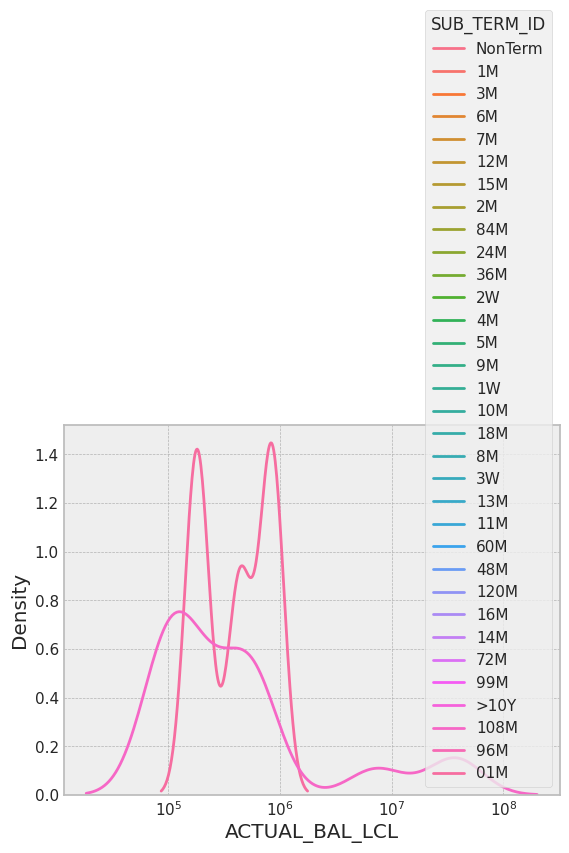

In [ ]:
sns.kdeplot(tmp, x='ACTUAL_BAL_LCL', 
            hue='SUB_TERM_ID', 
            log_scale=True,
            # multiple='fill',
            # bw_adjust=.2
            # palette=['springgreen', 'cyan', 'dodgerblue'], 
            # legend=False,
            # fill=True,
            common_norm=False,
            # native_scale=True,
            # col='CUST_STATUS',
           )

In [ ]:
tmp = tmp[(tmp['SUB_TERM_ID'].isin(['NonTerm', 
                                   '12M', 
                                   '6M', 
                                   # '1M', 
                                   # '3M'
                                  ])) & 
          (tmp['ACTUAL_BAL_LCL'] > 0)
         ]

In [ ]:
# g = sns.FacetGrid(tmp, 
#                   col='CUST_STATUS', 
#                   hue='SUB_TERM_ID', 
#                   palette=sns.color_palette('viridis'),
#                   # palette=['springgreen', 'cyan', 'dodgerblue'], 
#                   # row='TRAN_STATUS', 
#                   margin_titles=True, despine=True, height=4, aspect=1,
                  
#                  )
# g.map_dataframe(sns.kdeplot, 
#                 x='ACTUAL_BAL_LCL',
#                 common_norm=False,
#                 log_scale=True,
#                 legend=True,
#                )
# g.refline(x=tmp['ACTUAL_BAL_LCL'].median(),lw=1, c='orange')
# # g.figure.subplots_adjust(wspace=0, hspace=0)
# for ax in g.figure.axes:
#     ax.tick_params(labelrotation=45)

In [ ]:
# g = sns.FacetGrid(tmp, 
#                   col='SUB_TERM_ID', 
#                   hue='CUST_STATUS', 
#                   # palette=sns.color_palette('viridis'),
#                   palette=['springgreen', 'cyan', 'dodgerblue'], 
#                   # row='TRAN_STATUS', 
#                   margin_titles=True, despine=True, height=4, aspect=1)
# g.map_dataframe(sns.kdeplot, 
#                 x='ACTUAL_BAL_LCL',
#                 common_norm=False,
#                 log_scale=True,
#                 legend=True,
#                )
# g.refline(x=tmp['ACTUAL_BAL_LCL'].median(), lw=1, c='orange')
# # g.figure.subplots_adjust(wspace=0, hspace=0)
# for ax in g.figure.axes:
#     ax.tick_params(labelrotation=45)

### TXN AMT

In [ ]:
stmt_ebank_df.columns

In [ ]:
# stmt_ebank_df = stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']]

In [ ]:
# sorted(stmt_ebank_df['PROCESS_DT'].unique())

In [ ]:
stmt_ebank_df.groupby('PROCESS_DT')['CUSTOMER_ID'].nunique().to_frame()

In [ ]:
tmp = stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']].copy()

In [ ]:
tmp1 = df3.copy().drop(columns=['PROCESS_DT'])

In [ ]:
df3['CUST_STATUS'].value_counts()

In [ ]:
tmp['CUSTOMER_ID'] = tmp['CUSTOMER_ID'].astype(str)

In [ ]:
tmp2 = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_ID', right_on='CUSTOMER_CDE')

In [ ]:
tmp2['TXN_TYPE'] = tmp2['AMT_LCY'].apply(lambda x: "OUT" if x < 0 else "IN")

In [ ]:
tmp2['ABS_AMT_LCY'] = abs(tmp2['AMT_LCY'])

In [ ]:
tmp2[tmp2['AMT_LCY']==0]

In [ ]:
# no txn zero amount

In [ ]:
ax = sns.lineplot(tmp2, x='PROCESS_DT', y='AMT_LCY', hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  style='TXN_TYPE', 
                  # markers=True,
                  orient='x')
# sns.pointplot(tmp2, x='PROCESS_DT', y='AMT_LCY', palette=['springgreen', 'cyan', 'dodgerblue'], hue='CUST_STATUS', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper right', bbox_to_anchor=(1,1.35))
plt.axhline(ls='--',lw=1)

In [ ]:
tmp3 = tmp2.groupby(['CUST_STATUS','PROCESS_DT'])['AMT_LCY'].sum()
tmp3 = tmp3.to_frame('NET_AMT').reset_index()
# sns.regplot(tmp3, x='PROCESS_DT', y='NET_AMT')

In [ ]:
ax = sns.pointplot(tmp3, x='PROCESS_DT', y='NET_AMT', palette=['springgreen', 'cyan', 'dodgerblue'], hue='CUST_STATUS')
ax.tick_params(axis='x', rotation=45)

In [ ]:
tmp3 = tmp2.groupby(['CUST_STATUS','CUSTOMER_CDE', 'TXN_TYPE'])['ABS_AMT_LCY'].max()
tmp3 = tmp3.to_frame(name='MAX_AMT').reset_index()

In [ ]:
sns.displot(data=tmp3, x='MAX_AMT', hue='TXN_TYPE', kind='kde',multiple='layer', clip=(0, None), log_scale=True,
            # palette=['springgreen', 'cyan', 'dodgerblue'], 
           )

In [ ]:
tmp3 = tmp2.sort_values(by=['PROCESS_DT'], ascending=False)

In [ ]:
tmp2['CUST_STATUS'].value_counts()

In [ ]:
tmp4 = tmp3[(tmp3['TXN_TYPE']=='OUT') & (tmp3['CUST_STATUS']=='1. HOAT DONG')]
tmp5 = tmp3[(tmp3['TXN_TYPE']=='IN')& (tmp3['CUST_STATUS']=='1. HOAT DONG')]

In [ ]:
fig, ax = plt.subplots(1,1, )
sns.set_color_codes('pastel')
sns.barplot(tmp4, x='AMT_LCY', y='PROCESS_DT', errorbar='ci', label='Received', color='lightgreen',ax=ax)
sns.set_color_codes('muted')
sns.barplot(tmp5, x='AMT_LCY', y='PROCESS_DT', errorbar='ci', ax=ax, label='Transfer', color='springgreen')
ax.legend(prop={'size': 8})
ax.set(xlim=(-4*1e7, 4*1e7), ylabel="")
ax.set_title('CASA Avg Txn Amount\n of Active Customer')
sns.despine(left=True, bottom=True)
plt.show()


### NARRATIVE

In [ ]:
from wordcloud import WordCloud

In [ ]:
tmp = stmt_ebank_df.copy()
tmp.columns

In [ ]:
# stmt_ebank_df[['AMT_LCY', 'CUSTOMER_ID', 'PROCESS_DT']].copy()
tmp = tmp[['NARRATIVE', 'CUSTOMER_ID', 'PROCESS_DT','AMT_LCY']]

In [ ]:
tmp.columns = ['NARRATIVE','S_NARRATIVE','CUSTOMER_ID', 'PROCESS_DT','AMT_LCY']

In [ ]:
tmp1 = df3.copy().drop(columns=['PROCESS_DT'])

In [ ]:
tmp1['CUST_STATUS'].value_counts()

In [ ]:
tmp['CUSTOMER_ID'] = tmp['CUSTOMER_ID'].astype(str)

In [ ]:
tmp2 = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_ID', right_on='CUSTOMER_CDE')

In [ ]:
tmp2['TXN_TYPE'] = tmp2['AMT_LCY'].apply(lambda x: "OUT" if x < 0 else "IN")

In [ ]:
tmp2['ABS_AMT_LCY'] = abs(tmp2['AMT_LCY'])

In [ ]:
tmp3 = tmp2[['NARRATIVE', 'CUSTOMER_CDE','CUST_STATUS', 'TXN_TYPE']]

In [ ]:
tmp4 = tmp3.groupby([ 'CUST_STATUS', 'TXN_TYPE'])['NARRATIVE'].apply(lambda x: ' '.join(list(x)))

In [ ]:
tmp4

In [ ]:
wordcloud_img = WordCloud(background_color='white').generate(tmp4[0])
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis('off')

In [ ]:
wordcloud_img = WordCloud(background_color='white').generate(tmp4[1])
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis('off')

## CARD-CREDIT

In [ ]:
tmp = df3.copy()

In [ ]:
tmp['CUSTOMER_CDE'].nunique()

In [ ]:
tmp['PROCESS_DT'].unique()

In [ ]:
tmp['SD_CREDIT'] = tmp['SD_CREDIT'].fillna(0)

In [ ]:
tmp['CREDIT'] = tmp['CREDIT'].fillna(0)

In [ ]:
tmp[['CUSTOMER_CDE', 'SD_CREDIT']].drop_duplicates()['SD_CREDIT'].value_counts(dropna=False).sort_index().plot(kind='pie', autopct='%.2f%%', colors=['deepskyblue', 'orange'])

In [ ]:
tmp['CREDIT'].value_counts(dropna=False).loc[[1, 0]].plot(kind='pie', autopct='%.2f%%', colors=['orange', 'deepskyblue', 'lightgrey'])
plt.show()

In [ ]:
tmp1 = tmp[['SD_CREDIT','CUST_STATUS']].value_counts(dropna=False, normalize=True)
tmp1 = tmp1.to_frame('prop').reset_index().sort_values(by=['SD_CREDIT', 'CUST_STATUS'])

In [ ]:
fig,ax=plt.subplots(1,1, figsize=(10,8))
sns.barplot(tmp1,x='SD_CREDIT',hue='CUST_STATUS',y='prop',palette=['springgreen', 'cyan', 'dodgerblue'], gap=0.1, fill=True,ax=ax)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='best', )
plt.grid()
plt.show()

In [ ]:
tmp.groupby(['SD_CREDIT','CUST_STATUS','CREDIT'])['CUSTOMER_CDE'].nunique()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
tmp[tmp['SD_CREDIT']==1]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[1], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
tmp[tmp['SD_CREDIT']==0]['CUST_STATUS'].value_counts(normalize=True).sort_index().plot(kind='pie', ax=axes[0], colors=['springgreen', 'cyan', 'dodgerblue'], autopct='%.2f%%')
axes[1].set_title('Co su dung CREDIT')
axes[0].set_title('Ko su dung CREDIT')
plt.show()

### CARD_CREDIT BAL NOW

In [ ]:
tmp = card_credit_bal_now.copy()

In [ ]:
tmp1 = cust_status.copy()

In [ ]:
tmp = tmp.merge(tmp1, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
sns.kdeplot(tmp, x='CARD_CREDIT_SUM_BAL_NOW', log_scale=True, hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], common_norm=False)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxenplot(tmp, hue='CUST_STATUS', y='CARD_CREDIT_SUM_BAL_NOW', width_method='linear',palette=['springgreen', 'cyan', 'dodgerblue'], gap=.1,
              ax=ax,
              log_scale=True,
              k_depth='proportion', 
              # medianprops={'color':'r'},
             )
ax.legend(prop={'size':8})
plt.show()

### CARD_TXN

In [ ]:
tmp = df3.copy()

In [ ]:
card_txn.TRAN_STATUS.value_counts(dropna=False)

In [ ]:
# card_txn = card_txn[card_txn['TRAN_STATUS']=='S']

In [ ]:
card_txn.columns

In [ ]:
tmp1 = tmp.merge(card_txn, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
tmp1['SD_CREDIT'].fillna(0, inplace=True)

In [ ]:
# tmp1 = tmp[tmp['SD_CREDIT']==1].merge(card_txn, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
tmp1['SD_CREDIT'].value_counts(dropna=False)

In [ ]:
tmp1['LOG_AMT_BILL'] = np.log10(tmp1['AMT_BILL'])

In [ ]:
# ax = sns.relplot(tmp1, x='PROCESS_DT_y', y='LOG_AMT_BILL', 
#                  hue='CUST_STATUS', 
#                  palette=['springgreen', 'cyan', 'dodgerblue'], 
#                  col='SD_CREDIT',
#                  kind='line',
#                  # native_scale=True,
#                  # log_scale=True,
#                 )
# ax.tick_params(axis='x', rotation=60)
# # ax.set_ylim([None, None])
# plt.show()

In [ ]:
tmp2 = tmp1.groupby(['PROCESS_DT_y', 'CUST_STATUS', 'CUSTOMER_CDE', 'SD_CREDIT', 'TRAN_STATUS'])['AMT_BILL'].sum().to_frame().reset_index()

In [ ]:
tmp2 = tmp2.rename(columns={'PROCESS_DT_y': 'PROCESS_DT'})

In [ ]:
tmp2['PROCESS_DT'] = pd.to_datetime(tmp2['PROCESS_DT'])

In [ ]:
tmp3 = tmp2.groupby([pd.Grouper(key='PROCESS_DT', axis=0,freq='1M', sort=True), 'CUST_STATUS', 'CUSTOMER_CDE', 'SD_CREDIT', 'TRAN_STATUS'])['AMT_BILL'].sum().reset_index()
tmp3['AMT_BILL'] = np.log10(tmp3['AMT_BILL'])

ax = sns.relplot(tmp3, x='PROCESS_DT', y='AMT_BILL', hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  style='SD_CREDIT',
                 kind='line',
                 col='TRAN_STATUS',
                 # native_scale=True,
                 # log_scale=True,
                )
ax.tick_params(axis='x', rotation=60)
# ax.set_ylim([None, None])
plt.show()

In [ ]:
g = sns.FacetGrid(tmp3, 
                  col='SD_CREDIT', 
                  hue='CUST_STATUS', palette=['springgreen', 'cyan', 'dodgerblue'], 
                  # row='TRAN_STATUS', 
                  margin_titles=True, despine=True, height=4, aspect=1)
g.map_dataframe(sns.lineplot, x='PROCESS_DT', y='AMT_BILL')
g.refline(y=tmp3['AMT_BILL'].median())
# g.figure.subplots_adjust(wspace=0, hspace=0)
for ax in g.figure.axes:
    ax.tick_params(labelrotation=45)
# plt.xticks(rotation=45)

# REACTIVATED

In [ ]:
reactivated_data['REACTIVATED'] = (reactivated_data['CUST_STT'] == 2) & (reactivated_data['CUST_STT_CHG'] == 1)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
reactivated_data['REACTIVATED'].value_counts().plot(kind='bar', ax=axes[0])
reactivated_data['REACTIVATED'].value_counts().plot(kind='pie',autopct='%.2f%%', ax=axes[1])
plt.show()

In [ ]:
# map voi random sample
tmp = df3.copy()
tmp = tmp[['CUSTOMER_CDE']].merge(reactivated_data, how='inner', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
tmp['REACTIVATED'].value_counts().plot(kind='bar', ax=axes[0])
tmp['REACTIVATED'].value_counts().plot(kind='pie',autopct='%.2f%%', ax=axes[1])
plt.show()

In [ ]:
# ti le REACTIVATE dc giu nguyen rat tot